## Load Dataset into the Notebook

In [17]:
import pandas as pd

# Load the dataset by reading the entire line and splitting it manually
train_path = r'../data/train.ft.txt'
test_path = r'../data/test.ft.txt'

# Define a custom function to load the data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Split the label and text at the first space
            label, text = line.split(' ', 1)
            data.append([label, text.strip()])
    return pd.DataFrame(data, columns=['label', 'text'])

# Load train and test data using the custom function
train_data = load_data(train_path)
test_data = load_data(test_path)

# Display the first few rows to verify
train_data.head()


,label,text
0,__label__2,Stuning even for the non-gamer: This sound tra...
1,__label__2,The best soundtrack ever to anything.: I'm rea...
2,__label__2,Amazing!: This soundtrack is my favorite music...
3,__label__2,Excellent Soundtrack: I truly like this soundt...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He..."


In [18]:
train_data.shape


(3600000, 2)

In [19]:
test_data.shape

(400000, 2)

## Sample Data with Class Balance

In [20]:
# Check the distribution of the classes
print("Class distribution in training data:")
print(train_data['label'].value_counts())

Class distribution in training data:
label
__label__2    1800000
__label__1    1800000
Name: count, dtype: int64


In [21]:


# Sample 25,000 from each class for balanced training data
train_sample_1 = train_data[train_data['label'] == '__label__1'].sample(n=25000, random_state=42)
train_sample_2 = train_data[train_data['label'] == '__label__2'].sample(n=25000, random_state=42)

# Combine to create balanced training data
train_data_sampled = pd.concat([train_sample_1, train_sample_2]).reset_index(drop=True)

# Verify class distribution
print(train_data_sampled['label'].value_counts())


label
__label__1    25000
__label__2    25000
Name: count, dtype: int64


In [23]:
# Sample 5,000 rows from each class for balanced test data
test_sample_1 = test_data[test_data['label'] == '__label__1'].sample(n=5000, random_state=42)
test_sample_2 = test_data[test_data['label'] == '__label__2'].sample(n=5000, random_state=42)

# Combine to create balanced test data
test_data_sampled = pd.concat([test_sample_1, test_sample_2]).reset_index(drop=True)

# Verify class distribution
print(test_data_sampled['label'].value_counts())


label
__label__1    5000
__label__2    5000
Name: count, dtype: int64


##  Text Preprocessing

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Himanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Himanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Apply preprocessing to the dataset
train_data_sampled['cleaned_text'] = train_data_sampled['text'].apply(preprocess_text)

# Display cleaned training data
train_data_sampled[['text', 'cleaned_text']].head()


,text,cleaned_text
0,The History of Torture and Execution: I have n...,history torture execution yet received book or...
1,Stainless Steel shouldn't corrode... should it...,stainless steel shouldnt corrode really please...
2,Another Weak Sequel To A Once Promising Franch...,another weak sequel promising franchise hellra...
3,"Simply Awful: Contrived, trite, ""Bridget Jones...",simply awful contrived trite bridget joness di...
4,"FLASH: Jeff Beck's Flash In my opinion, was no...",flash jeff becks flash opinion one better albu...


In [26]:
# Preprocess the test data
test_data_sampled['cleaned_text'] = test_data_sampled['text'].apply(preprocess_text)

# Display cleaned test data
test_data_sampled[['text', 'cleaned_text']].head()


,text,cleaned_text
0,Buyer beware-- too good to be true: I bought t...,buyer beware good true bought tricycle son alm...
1,Returned to Amazon: After reading some great r...,returned amazon reading great reviews ive deci...
2,Poor quality: Bungee cord ripped first time I ...,poor quality bungee cord ripped first time use...
3,Too basic: The book title is misleading. I tho...,basic book title misleading thought would comp...
4,Warranty?: This product lasted 14 months for m...,warranty product lasted months suitable purpos...


## Text Vectorization using TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit on the training data and transform both training and test data
X_train = vectorizer.fit_transform(train_data_sampled['cleaned_text'])
X_test = vectorizer.transform(test_data_sampled['cleaned_text'])


In [28]:
# Encode the labels
y_train = (train_data_sampled['label'] == '__label__2').astype(int)
y_test = (test_data_sampled['label'] == '__label__2').astype(int)

## Train Logistic Regression Model

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the Logistic Regression model
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8702

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



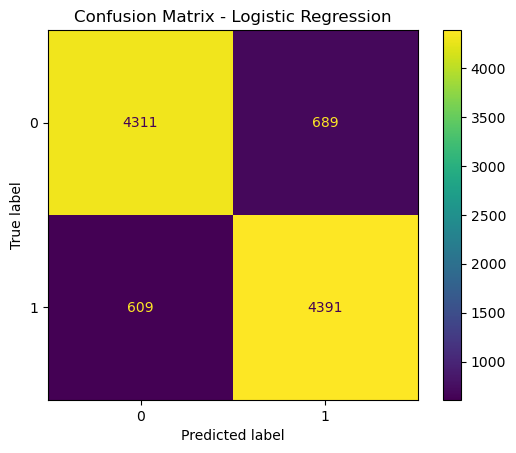

In [36]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Set relative path for the output directory
output_dir = '../output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig(os.path.join(output_dir, 'confusion_matrix_logistic_regression.png'))
plt.show()



In [34]:
## Model Training with other algorithmes

'C:\\Users\\Himanshu\\Customer Sentiment Analysis\\notebooks'

In [37]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Generic function for model training and evaluation
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Get predicted probabilities for ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Classification report
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} ROC-AUC Score: {roc_auc:.4f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

    # Save the plot
    output_dir = '../output'
    plt.savefig(os.path.join(output_dir, f'roc_curve_{model_name.lower()}.png'))
    plt.show()

Logistic Regression Accuracy: 0.8702

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Logistic Regression ROC-AUC Score: 0.9432


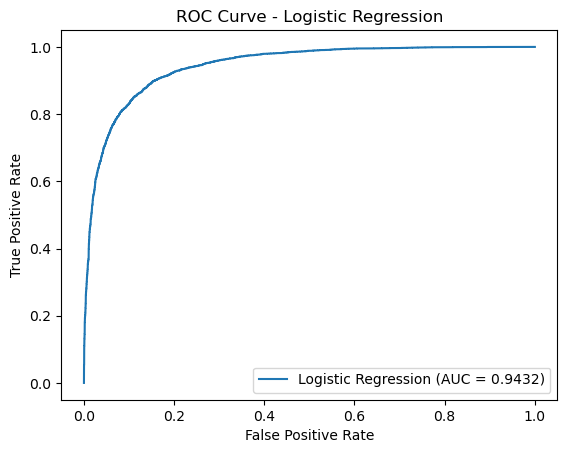

Random Forest Accuracy: 0.8415

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5000
           1       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Random Forest ROC-AUC Score: 0.9196


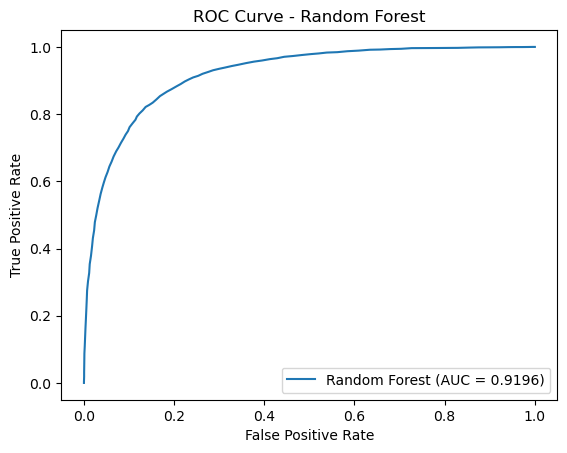

C:\Users\Himanshu\anaconda3\envs\sentiment-analysis-env\lib\site-packages\xgboost\core.py:158: UserWarning: [11:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8435

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5000
           1       0.84      0.85      0.85      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

XGBoost ROC-AUC Score: 0.9235


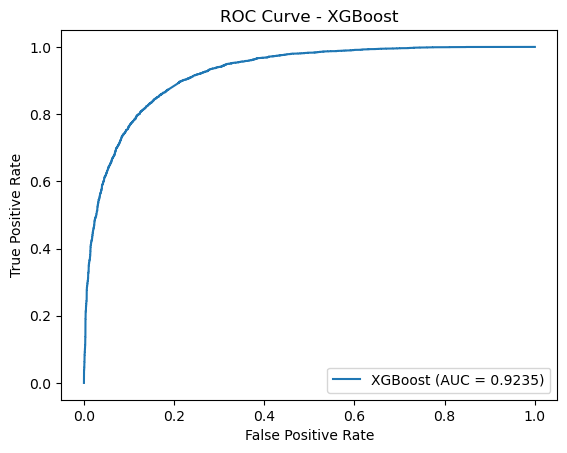

In [40]:

# Example usage for Logistic Regression, Random Forest, and XGBoost:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Instantiate models
log_reg = LogisticRegression(max_iter=100)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluate all models
models = [log_reg, random_forest, xgboost_model]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

for model, name in zip(models, model_names):
    evaluate_model(model, name, X_train, y_train, X_test, y_test)

## Metrics Summary: 

1) Logistic Regression:
ROC-AUC: 0.9432 (indicating excellent discrimination).
Confusion Matrix: Shows balanced predictions but with slightly more false positives (689).

2) Random Forest:
ROC-AUC: 0.9196 (strong but slightly lower than Logistic Regression).

3) XGBoost:
ROC-AUC: 0.9235 (better than Random Forest, slightly lower than Logistic Regression).

## LSTM Implementation
implement a basic LSTM (Long Short-Term Memory) model for sentiment analysis using your preprocessed text data.

In [43]:
pip install tensorflow keras

  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
  Using cached tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp38-cp38-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp38-cp38-win_amd64.whl.metadata (

In [49]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

In [45]:
# Tokenizing the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data_sampled['cleaned_text'])

In [46]:

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data_sampled['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data_sampled['cleaned_text'])

In [47]:
# Padding sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [50]:

# Encode labels as integers
encoder = LabelEncoder()
y_train_lstm = encoder.fit_transform(y_train)
y_test_lstm = encoder.transform(y_test)

In [51]:
# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [53]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
# Train the model
model.fit(X_train_pad, y_train_lstm, batch_size=64, epochs=5, validation_data=(X_test_pad, y_test_lstm))



Epoch 1/5
782/782 [==============================] - 742s 945ms/step - loss: 0.3587 - accuracy: 0.8422 - val_loss: 0.2916 - val_accuracy: 0.8817
Epoch 2/5
782/782 [==============================] - 802s 1s/step - loss: 0.2540 - accuracy: 0.8969 - val_loss: 0.2829 - val_accuracy: 0.8813
Epoch 3/5
782/782 [==============================] - 826s 1s/step - loss: 0.2150 - accuracy: 0.9139 - val_loss: 0.2946 - val_accuracy: 0.8774
Epoch 4/5
782/782 [==============================] - 905s 1s/step - loss: 0.1837 - accuracy: 0.9285 - val_loss: 0.3348 - val_accuracy: 0.8752
Epoch 5/5
782/782 [==============================] - 844s 1s/step - loss: 0.1559 - accuracy: 0.9404 - val_loss: 0.3550 - val_accuracy: 0.8755


In [55]:
# Evaluate the model
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test_lstm, y_pred_lstm))

313/313 [==============================] - 20s 63ms/step
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5000
           1       0.86      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## AUC-ROC Calculation and Plot

313/313 [==============================] - 14s 43ms/step
LSTM ROC-AUC Score: 0.9407


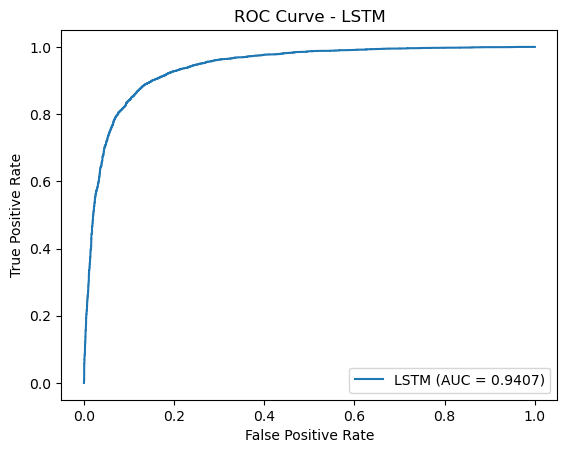

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for ROC-AUC calculation
y_pred_lstm_proba = model.predict(X_test_pad)

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test_lstm, y_pred_lstm_proba)
print(f"LSTM ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_lstm, y_pred_lstm_proba)
plt.plot(fpr, tpr, label=f"LSTM (AUC = {roc_auc:.4f})")
plt.title('ROC Curve - LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Save the plot
output_dir = '../output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'roc_curve_lstm.png'))
plt.show()


In [58]:
## Model Performance Summary

In [59]:
import pandas as pd
from IPython.display import display

# Data for the table
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LSTM'],
    'Accuracy': [0.8702, 0.8415, 0.8435, 0.88],
    'Precision (Class 0)': [0.88, 0.84, 0.85, 0.89],
    'Recall (Class 0)': [0.86, 0.84, 0.83, 0.86],
    'Precision (Class 1)': [0.86, 0.84, 0.84, 0.86],
    'Recall (Class 1)': [0.88, 0.84, 0.85, 0.89],
    'AUC': [0.9432, 0.9196, 0.9235, 0.9407]
}

# Create DataFrame
df = pd.DataFrame(data)
display(df)


,Model,Accuracy,Precision (Class 0),Recall (Class 0),Precision (Class 1),Recall (Class 1),AUC
0,Logistic Regression,0.8702,0.88,0.86,0.86,0.88,0.9432
1,Random Forest,0.8415,0.84,0.84,0.84,0.84,0.9196
2,XGBoost,0.8435,0.85,0.83,0.84,0.85,0.9235
3,LSTM,0.8800,0.89,0.86,0.86,0.89,0.9407


## Future Recommendations

1) Model Tuning: Fine-tune hyperparameters for LSTM or XGBoost for further improvements.
2)  Try models like SVM or deep learning architectures for further experimentation.
3) Consider handling class imbalance using techniques like SMOTE or class weighting.
4) Ensemble Models: Use a voting classifier or stacking to combine the strengths of multiple models.